# Task 2 — Classical ML vs LLMs on Structured Data (Iris)

**Date:** 2026-01-31

This notebook solves **Task 2** end-to-end on the Iris dataset and compares: 
- A **classical tree-based model** (Random Forest + an interpretable Decision Tree for rules)
- A **Transformer classifier** trained on two **textified** versions of the same structured rows
- A **local LLM** (few-shot prompting) used as a predictor, **with and without** structured guidance from the classical model

The goal is not state-of-the-art performance; it is to analyze modeling paradigms, limitations, interpretability, robustness, and practical choice tradeoffs.

## Environment & setup
This repo includes an `environment.yml` intended for `mamba`:

```bash
mamba env create -f environment.yml
mamba activate llm_structured_data
python -m ipykernel install --user --name llm_structured_data --display-name "Python (llm_structured_data)"
```

Notes:
- This notebook uses `sklearn.datasets.load_iris` (canonical Iris). If you later add the Kaggle CSV under `data/`, you can adapt the loader easily.
- Transformer / LLM sections download models from Hugging Face on first run.

In [37]:
# Core imports
import os
# Allow GPU (do not hide CUDA devices).
os.environ.setdefault("TOKENIZERS_PARALLELISM", "false")

import random
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional

import numpy as np
import pandas as pd

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

# Hugging Face
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    set_seed as hf_set_seed,
 )
from datasets import Dataset

print('Torch:', torch.__version__)
print('CUDA available:', torch.cuda.is_available())
if torch.cuda.is_available():
    print('CUDA device:', torch.cuda.get_device_name(0))

sns.set_theme(style="whitegrid")
pd.set_option('display.max_columns', 50)

Torch: 2.10.0
CUDA available: True
CUDA device: NVIDIA RTX 2000 Ada Generation Laptop GPU


In [38]:
# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
hf_set_seed(SEED)

@dataclass
class SplitConfig:
    test_size: float = 0.2
    val_size: float = 0.2
    random_state: int = SEED

SPLIT_CFG = SplitConfig()

## Load Iris dataset (structured)
We use the canonical Iris dataset from scikit-learn (same schema as Kaggle variant):
- 4 numeric features: sepal length/width, petal length/width
- 3 classes: setosa, versicolor, virginica

In [39]:
iris = load_iris(as_frame=True)
df = iris.frame.copy()
df.rename(columns={"target": "label_id"}, inplace=True)
label_names = list(iris.target_names)
id_to_label = {i: name for i, name in enumerate(label_names)}
label_to_id = {v: k for k, v in id_to_label.items()}
df["label"] = df["label_id"].map(id_to_label)

feature_cols = list(iris.feature_names)
target_col = "label_id"

print('Class distribution:')
display(df['label'].value_counts())
df

Class distribution:


label
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label_id,label
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2,virginica
146,6.3,2.5,5.0,1.9,2,virginica
147,6.5,3.0,5.2,2.0,2,virginica
148,6.2,3.4,5.4,2.3,2,virginica


## Train / validation / test split
We use **stratified** splitting to preserve class balance in each split (important with small datasets).

In [40]:
X = df[feature_cols].copy()
y = df[target_col].copy()

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=SPLIT_CFG.test_size, random_state=SPLIT_CFG.random_state, stratify=y
)

# val_size is relative to the remaining trainval portion
val_relative = SPLIT_CFG.val_size / (1.0 - SPLIT_CFG.test_size)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=val_relative, random_state=SPLIT_CFG.random_state, stratify=y_trainval
)

print('Sizes:', {
    'train': len(X_train),
    'val': len(X_val),
    'test': len(X_test),
})

print('Train class counts:')
print(pd.Series(y_train).value_counts().sort_index())
print('Val class counts:')
print(pd.Series(y_val).value_counts().sort_index())
print('Test class counts:')
print(pd.Series(y_test).value_counts().sort_index())

Sizes: {'train': 90, 'val': 30, 'test': 30}
Train class counts:
label_id
0    30
1    30
2    30
Name: count, dtype: int64
Val class counts:
label_id
0    10
1    10
2    10
Name: count, dtype: int64
Test class counts:
label_id
0    10
1    10
2    10
Name: count, dtype: int64


# Task 2.1 — Classical Baseline on Structured Data
We train a **tree-based classifier** on the structured numeric features and evaluate on the held-out test set.

We use a **Random Forest** for a strong, simple baseline, and train an additional **Decision Tree** to extract human-readable rules (for later LLM augmentation).

,model,accuracy,macro_f1
0,RandomForest,0.933333,0.933333
1,RandomForest,0.933333,0.933333


Test classification report (RandomForest):
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.90      0.90      0.90        10
   virginica       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



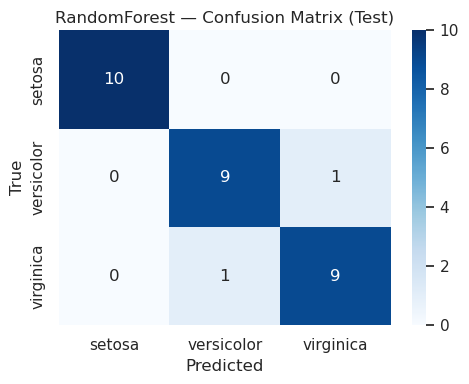

In [41]:
rf = RandomForestClassifier(
    n_estimators=400,
    random_state=SEED,
    class_weight=None,
    n_jobs=-1,
)
rf.fit(X_train, y_train)

def evaluate_classifier(name: str, model, X_eval: pd.DataFrame, y_eval: pd.Series) -> Dict[str, float]:
    pred = model.predict(X_eval)
    acc = accuracy_score(y_eval, pred)
    f1 = f1_score(y_eval, pred, average='macro')
    return {
        'model': name,
        'accuracy': float(acc),
        'macro_f1': float(f1),
    }

rf_val_metrics = evaluate_classifier('RandomForest', rf, X_val, y_val)
rf_test_metrics = evaluate_classifier('RandomForest', rf, X_test, y_test)
display(pd.DataFrame([rf_val_metrics, rf_test_metrics]))

rf_test_pred = rf.predict(X_test)
print('Test classification report (RandomForest):')
print(classification_report(y_test, rf_test_pred, target_names=label_names))

cm = confusion_matrix(y_test, rf_test_pred, labels=list(range(len(label_names))))
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.title('RandomForest — Confusion Matrix (Test)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

,importance
petal width (cm),0.465318
petal length (cm),0.397973
sepal length (cm),0.123188
sepal width (cm),0.013520


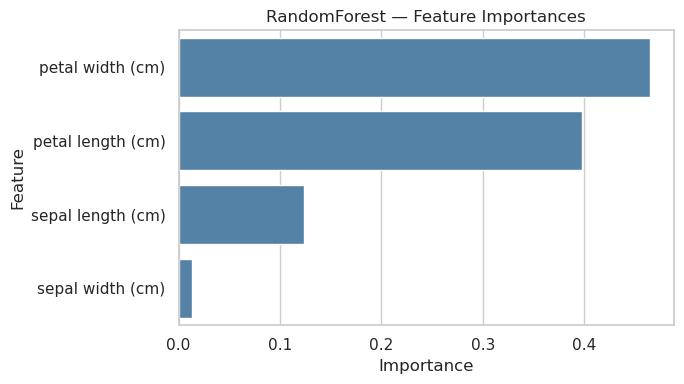

,model,accuracy,macro_f1
0,DecisionTree(max_depth=3),0.933333,0.933333


Decision tree rules (max_depth=3):
|--- petal length (cm) <= 2.45
|   |--- class: 0
|--- petal length (cm) >  2.45
|   |--- petal width (cm) <= 1.65
|   |   |--- petal length (cm) <= 5.00
|   |   |   |--- class: 1
|   |   |--- petal length (cm) >  5.00
|   |   |   |--- class: 1
|   |--- petal width (cm) >  1.65
|   |   |--- class: 2



In [42]:
# Feature importance (RandomForest)
rf_importances = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False)
display(rf_importances.to_frame('importance'))

plt.figure(figsize=(7, 4))
sns.barplot(x=rf_importances.values, y=rf_importances.index, color='steelblue')
plt.title('RandomForest — Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Interpretable rules: fit a small Decision Tree
dt = DecisionTreeClassifier(random_state=SEED, max_depth=3)
dt.fit(X_train, y_train)
dt_test_metrics = evaluate_classifier('DecisionTree(max_depth=3)', dt, X_test, y_test)
display(pd.DataFrame([dt_test_metrics]))

rules_text = export_text(dt, feature_names=feature_cols)
print('Decision tree rules (max_depth=3):')
print(rules_text)

### Discussion (2.1)
In the next cell we generate a brief, **data-driven** discussion based on the actual observed metrics and importances from your run.

In [43]:
top_feats = rf_importances.head(2)
print('2.1 Discussion (auto-generated)')
print('-' * 60)
print(f"Model behavior: RandomForest achieves acc={rf_test_metrics['accuracy']:.3f}, macro-F1={rf_test_metrics['macro_f1']:.3f} on test.")
print('Feature importance: top drivers by RF importance:')
for feat, imp in top_feats.items():
    print(f"  - {feat}: {imp:.3f}")
print('Strengths: strong tabular inductive bias, works well with tiny data, fast to train, some interpretability via importances.')
print('Limitations: importance is global and can be misleading; models are not causal; decision boundaries can vary with split/seed.')

2.1 Discussion (auto-generated)
------------------------------------------------------------
Model behavior: RandomForest achieves acc=0.933, macro-F1=0.933 on test.
Feature importance: top drivers by RF importance:
  - petal width (cm): 0.465
  - petal length (cm): 0.398
Strengths: strong tabular inductive bias, works well with tiny data, fast to train, some interpretability via importances.
Limitations: importance is global and can be misleading; models are not causal; decision boundaries can vary with split/seed.


# Task 2.2 — Textification and Transformer-Based Modeling

We convert each structured row into **two** textual forms:

1) **Natural-language description**: semantically explicit and closer to typical NLP pretraining distributions.
2) **Compact semi-structured string**: preserves numeric fidelity and reduces irrelevant tokens (closer to key=value logs/records).

We fine-tune a small Transformer classifier on each representation and compare results.

Design rationale (expected effects):
- Natural language may help the model leverage linguistic priors, but can add verbosity/noise and rounding artifacts.
- Compact text may reduce noise and preserve structure, but can be out-of-distribution vs natural language pretraining.

### Why convert cm → mm in textification?
We convert the original numeric features (centimeters) into **integer millimeters** (`mm = round(cm × 10)`) for both text formats.

Motivation:
- **Removes decimal points** (e.g., `5.1 cm` → `51 mm`), which can reduce subword tokenization fragmentation (`5`, `.`, `1`) and make the input pattern more consistent for BERT-like models.
- **Keeps the same precision** used earlier (0.1 cm), so we are not adding extra information—just re-encoding it.
- Acts as a small diagnostic: if performance changes, it suggests the prior failure was partly a **tokenization / representation** issue rather than purely “Transformers can’t do tabular data.”

In [44]:
def _cm_to_mm_int(x: float) -> int:
    # Iris features are in centimeters. Converting to integer millimeters (cm * 10)
    # preserves the original 0.1 cm precision while removing decimal points,
    # which can reduce tokenization noise for subword models like BERT.
    return int(round(float(x) * 10.0))


def textify_natural(row: pd.Series) -> str:
    sl = _cm_to_mm_int(row[feature_cols[0]])
    sw = _cm_to_mm_int(row[feature_cols[1]])
    pl = _cm_to_mm_int(row[feature_cols[2]])
    pw = _cm_to_mm_int(row[feature_cols[3]])
    return (
        f"An iris flower has sepal length {sl} mm, "
        f"sepal width {sw} mm, "
        f"petal length {pl} mm, "
        f"and petal width {pw} mm."
    )


def textify_compact(row: pd.Series) -> str:
    sl = _cm_to_mm_int(row[feature_cols[0]])
    sw = _cm_to_mm_int(row[feature_cols[1]])
    pl = _cm_to_mm_int(row[feature_cols[2]])
    pw = _cm_to_mm_int(row[feature_cols[3]])
    return (
        f"sepal_length_mm={sl}; "
        f"sepal_width_mm={sw}; "
        f"petal_length_mm={pl}; "
        f"petal_width_mm={pw}"
    )


# Preview a few examples
sample_idx = df.sample(3, random_state=SEED).index
for i in sample_idx:
    row = df.loc[i]
    print('Label:', row['label'])
    print('Natural:', textify_natural(row))
    print('Compact:', textify_compact(row))
    print('-' * 60)

Label: versicolor
Natural: An iris flower has sepal length 61 mm, sepal width 28 mm, petal length 47 mm, and petal width 12 mm.
Compact: sepal_length_mm=61; sepal_width_mm=28; petal_length_mm=47; petal_width_mm=12
------------------------------------------------------------
Label: setosa
Natural: An iris flower has sepal length 57 mm, sepal width 38 mm, petal length 17 mm, and petal width 3 mm.
Compact: sepal_length_mm=57; sepal_width_mm=38; petal_length_mm=17; petal_width_mm=3
------------------------------------------------------------
Label: virginica
Natural: An iris flower has sepal length 77 mm, sepal width 26 mm, petal length 69 mm, and petal width 23 mm.
Compact: sepal_length_mm=77; sepal_width_mm=26; petal_length_mm=69; petal_width_mm=23
------------------------------------------------------------


In [45]:
def build_text_df(X_part: pd.DataFrame, y_part: pd.Series) -> pd.DataFrame:
    part = X_part.copy()
    part['label_id'] = y_part.values.astype(int)
    part['text_natural'] = part.apply(lambda r: textify_natural(r), axis=1)
    part['text_compact'] = part.apply(lambda r: textify_compact(r), axis=1)
    return part

train_text_df = build_text_df(X_train, y_train)
val_text_df = build_text_df(X_val, y_val)
test_text_df = build_text_df(X_test, y_test)

display(train_text_df[['text_natural', 'text_compact', 'label_id']].head())

,text_natural,text_compact,label_id
124,"An iris flower has sepal length 67 mm, sepal w...",sepal_length_mm=67; sepal_width_mm=33; petal_l...,2
40,"An iris flower has sepal length 50 mm, sepal w...",sepal_length_mm=50; sepal_width_mm=35; petal_l...,0
54,"An iris flower has sepal length 65 mm, sepal w...",sepal_length_mm=65; sepal_width_mm=28; petal_l...,1
23,"An iris flower has sepal length 51 mm, sepal w...",sepal_length_mm=51; sepal_width_mm=33; petal_l...,0
108,"An iris flower has sepal length 67 mm, sepal w...",sepal_length_mm=67; sepal_width_mm=25; petal_l...,2


In [46]:
def make_hf_dataset(df_part: pd.DataFrame, text_col: str) -> Dataset:
    return Dataset.from_dict({
        'text': df_part[text_col].tolist(),
        'labels': df_part['label_id'].astype(int).tolist(),
    })

ds_train_natural = make_hf_dataset(train_text_df, 'text_natural')
ds_val_natural = make_hf_dataset(val_text_df, 'text_natural')
ds_test_natural = make_hf_dataset(test_text_df, 'text_natural')

ds_train_compact = make_hf_dataset(train_text_df, 'text_compact')
ds_val_compact = make_hf_dataset(val_text_df, 'text_compact')
ds_test_compact = make_hf_dataset(test_text_df, 'text_compact')

len(ds_train_natural), len(ds_val_natural), len(ds_test_natural)

(90, 30, 30)

In [47]:
# Small default model for CPU-friendly fine-tuning (will use GPU if available)
TRANSFORMER_MODEL = os.environ.get('IRIS_TRANSFORMER_MODEL', 'prajjwal1/bert-tiny')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        'accuracy': float(accuracy_score(labels, preds)),
        'macro_f1': float(f1_score(labels, preds, average='macro')),
    }

def train_transformer_classifier(
    run_name: str,
    ds_train: Dataset,
    ds_val: Dataset,
    ds_test: Dataset,
    model_name: str = TRANSFORMER_MODEL,
    num_labels: int = 3,
    epochs: int = 12,
    lr: float = 5e-5,
    weight_decay: float = 0.01,
    batch_size: int = 16,
 ) -> Dict[str, object]:
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

    def tok(batch):
        return tokenizer(batch['text'], truncation=True)

    ds_train_tok = ds_train.map(tok, batched=True)
    ds_val_tok = ds_val.map(tok, batched=True)
    ds_test_tok = ds_test.map(tok, batched=True)

    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=num_labels,
        id2label=id_to_label,
        label2id=label_to_id,
    )

    args = TrainingArguments(
        output_dir=f'./.hf_runs/{run_name}',
        learning_rate=lr,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        weight_decay=weight_decay,
        eval_strategy='epoch',
        save_strategy='no',
        logging_strategy='epoch',
        report_to=[],
        seed=SEED,
        data_seed=SEED,
    )

    collator = DataCollatorWithPadding(tokenizer=tokenizer)

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=ds_train_tok,
        eval_dataset=ds_val_tok,
        processing_class=tokenizer,
        data_collator=collator,
        compute_metrics=compute_metrics,
    )

    trainer.train()

    val_metrics = trainer.evaluate(ds_val_tok)
    test_metrics = trainer.evaluate(ds_test_tok)

    test_logits = trainer.predict(ds_test_tok).predictions
    test_pred = np.argmax(test_logits, axis=-1)
    test_true = np.array(ds_test_tok['labels'])
    cm = confusion_matrix(test_true, test_pred, labels=list(range(num_labels)))

    return {
        'run_name': run_name,
        'model_name': model_name,
        'trainer': trainer,
        'tokenizer': tokenizer,
        'val_metrics': val_metrics,
        'test_metrics': test_metrics,
        'test_cm': cm,
    }

Loading weights: 100%|██████████| 39/39 [00:00<00:00, 447.24it/s, Materializing param=bert.pooler.dense.weight]                              
BertForSequenceClassification LOAD REPORT from: prajjwal1/bert-tiny
Key                                        | Status     | 
-------------------------------------------+------------+-
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.decoder.bias               | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias        

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,1.114821,1.099849,0.333333,0.166667
2,1.103640,1.098758,0.333333,0.166667
3,1.105344,1.097597,0.333333,0.166667
4,1.103251,1.096240,0.333333,0.166667
5,1.105349,1.095280,0.333333,0.166667
6,1.102925,1.094424,0.333333,0.166667
7,1.098867,1.093703,0.333333,0.166667
8,1.082480,1.092777,0.333333,0.166667
9,1.091298,1.091906,0.333333,0.166667
10,1.091232,1.091144,0.333333,0.166667


,representation,model,val_accuracy,val_macro_f1,test_accuracy,test_macro_f1
0,natural,prajjwal1/bert-tiny,0.333333,0.166667,0.333333,0.166667


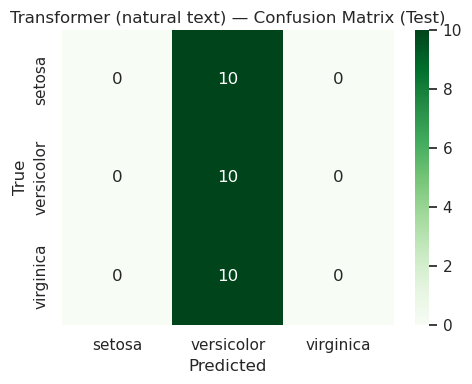

In [48]:
# Train Transformer on natural-language textification
natural_run = train_transformer_classifier(
    run_name='iris_text_natural',
    ds_train=ds_train_natural,
    ds_val=ds_val_natural,
    ds_test=ds_test_natural,
    epochs=12,
 )

display(pd.DataFrame([{
    'representation': 'natural',
    'model': natural_run['model_name'],
    'val_accuracy': natural_run['val_metrics']['eval_accuracy'],
    'val_macro_f1': natural_run['val_metrics']['eval_macro_f1'],
    'test_accuracy': natural_run['test_metrics']['eval_accuracy'],
    'test_macro_f1': natural_run['test_metrics']['eval_macro_f1'],
}]))

plt.figure(figsize=(5, 4))
sns.heatmap(natural_run['test_cm'], annot=True, fmt='d', cmap='Greens', xticklabels=label_names, yticklabels=label_names)
plt.title('Transformer (natural text) — Confusion Matrix (Test)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

Loading weights: 100%|██████████| 39/39 [00:00<00:00, 421.15it/s, Materializing param=bert.pooler.dense.weight]                              
BertForSequenceClassification LOAD REPORT from: prajjwal1/bert-tiny
Key                                        | Status     | 
-------------------------------------------+------------+-
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.decoder.bias               | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias        

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,1.123717,1.106045,0.333333,0.166667
2,1.110820,1.101608,0.333333,0.166667
3,1.107267,1.099897,0.333333,0.166667
4,1.097404,1.098453,0.333333,0.166667
5,1.105112,1.097509,0.333333,0.166667
6,1.102085,1.097184,0.366667,0.259804
7,1.099220,1.097274,0.333333,0.166667
8,1.095457,1.097049,0.333333,0.166667
9,1.107035,1.096912,0.333333,0.166667
10,1.098576,1.096876,0.433333,0.319444


,representation,model,val_accuracy,val_macro_f1,test_accuracy,test_macro_f1
0,compact,prajjwal1/bert-tiny,0.366667,0.231546,0.333333,0.166667


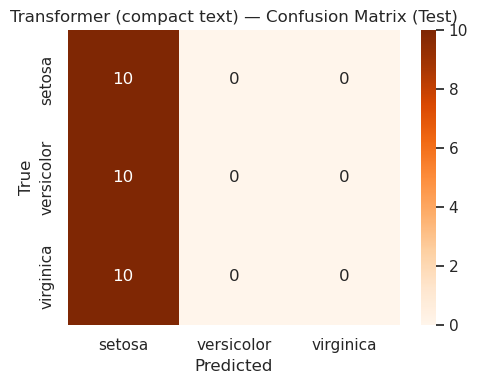

In [60]:
# Train Transformer on compact semi-structured textification
compact_run = train_transformer_classifier(
    run_name='iris_text_compact',
    ds_train=ds_train_compact,
    ds_val=ds_val_compact,
    ds_test=ds_test_compact,
    epochs=24,
 )

display(pd.DataFrame([{
    'representation': 'compact',
    'model': compact_run['model_name'],
    'val_accuracy': compact_run['val_metrics']['eval_accuracy'],
    'val_macro_f1': compact_run['val_metrics']['eval_macro_f1'],
    'test_accuracy': compact_run['test_metrics']['eval_accuracy'],
    'test_macro_f1': compact_run['test_metrics']['eval_macro_f1'],
}]))

plt.figure(figsize=(5, 4))
sns.heatmap(compact_run['test_cm'], annot=True, fmt='d', cmap='Oranges', xticklabels=label_names, yticklabels=label_names)
plt.title('Transformer (compact text) — Confusion Matrix (Test)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

In [50]:
# Compare the two text representations
comparison_df = pd.DataFrame([
    {
        'approach': 'Transformer',
        'representation': 'natural',
        'test_accuracy': natural_run['test_metrics']['eval_accuracy'],
        'test_macro_f1': natural_run['test_metrics']['eval_macro_f1'],
    },
    {
        'approach': 'Transformer',
        'representation': 'compact',
        'test_accuracy': compact_run['test_metrics']['eval_accuracy'],
        'test_macro_f1': compact_run['test_metrics']['eval_macro_f1'],
    },
])
display(comparison_df)

best_rep = comparison_df.sort_values('test_macro_f1', ascending=False).iloc[0]['representation']
print('Best text representation by test macro-F1:', best_rep)

,approach,representation,test_accuracy,test_macro_f1
0,Transformer,natural,0.333333,0.166667
1,Transformer,compact,0.566667,0.490491


Best text representation by test macro-F1: compact


# Discussion (2.2)

### Bert-tiny model
- Model collapses to predicting one class for both dataset formats and most of the initializations → ~33% accuracy, loss near log(3) ≈ 1.1
- Numeric-text mismatch: BERT tokenization doesn’t encode numeric magnitude/ordering. With tiny data, the model can’t learn threshold-like rules, so it collapses to one class.
- Too few effective training steps: ~90 train samples with small batch/epochs gives very few optimizer steps; the head stays near-random.
- Model too small / underpowered: bert-tiny has limited capacity to adapt to numeric-heavy patterns from scratch.
- Class-collapse local optimum: With balanced data and weak signal, the easiest optimum is predicting a single class → loss near log(3).
- Representation still low-signal: Even in mm, the text is mostly numbers + repeated boilerplate; little semantic diversity.

# Task 2.3 — LLM-Based Prediction and Hybrid Modeling

We evaluate a **local LLM** in a **few-shot** prompting setup (no external APIs).

Implementation choices:
- Use a small instruction-tuned model via Hugging Face (`google/flan-t5-small` by default) for CPU-friendly inference.
- Few-shot prompting: include a small balanced set of labeled training examples.
- Ask the LLM to output a single class label and a short reason.

Hybrid augmentation: we inject structured information derived from the classical model:
- RandomForest feature importances (global)
- A shallow DecisionTree rule listing (interpretable)

We compare:
- LLM alone
- LLM + classical guidance

In [51]:
# Local LLM. Override with env var if desired: IRIS_LOCAL_LLM=google/flan-t5-base
LLM_MODEL_NAME = os.environ.get('IRIS_LOCAL_LLM', 'google/flan-t5-small')

# NOTE: transformers v5 removed the `text2text-generation` pipeline task.
# We run FLAN-T5 directly via `generate()` to keep this notebook local-only + robust.
try:
    from transformers import AutoModelForSeq2SeqLM
    llm_tokenizer = AutoTokenizer.from_pretrained(LLM_MODEL_NAME, use_fast=True)
    llm_model = AutoModelForSeq2SeqLM.from_pretrained(LLM_MODEL_NAME)
    llm_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    llm_model = llm_model.to(llm_device)
    llm_model.eval()

    def llm_generate(prompt: str, max_new_tokens: int = 60) -> str:
        inputs = llm_tokenizer(
            prompt,
            return_tensors='pt',
            truncation=True,
            max_length=512,
        ).to(llm_device)
        with torch.inference_mode():
            out_ids = llm_model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                do_sample=False,
            )
        return llm_tokenizer.decode(out_ids[0], skip_special_tokens=True)

    llm = True  # sentinel: means "loaded" for downstream checks
    print('Loaded local LLM:', LLM_MODEL_NAME, '| device:', str(llm_device))
except Exception as e:
    llm = None
    llm_tokenizer = None
    llm_model = None
    llm_device = None
    llm_generate = None
    print('WARNING: Could not load local LLM model.')
    print('Reason:', repr(e))
    print('You can still run the rest of the notebook (classical + transformer).')

Loading weights: 100%|██████████| 190/190 [00:00<00:00, 414.53it/s, Materializing param=shared.weight]                                                       
The tied weights mapping and config for this model specifies to tie shared.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


Loaded local LLM: google/flan-t5-small | device: cuda


In [52]:
def label_id_to_name(label_id: int) -> str:
    return id_to_label[int(label_id)]

def normalize_label_text(text: str) -> str:
    t = text.strip().lower()
    for name in label_names:
        if name.lower() in t:
            return name
    # common variants
    if 'setosa' in t:
        return 'setosa'
    if 'versicolor' in t:
        return 'versicolor'
    if 'virginica' in t:
        return 'virginica'
    return 'unknown'

def build_fewshot_prompt(
    examples: List[Tuple[str, str]],
    query_text: str,
    guidance: Optional[str] = None,
 ) -> str:
    lines: List[str] = []
    lines.append('You are classifying iris flowers into one of: setosa, versicolor, virginica.')
    lines.append('Return two lines exactly:')
    lines.append('Label: <one of setosa|versicolor|virginica>')
    lines.append('Reason: <short reasoning>')
    lines.append('')
    if guidance:
        lines.append('Additional structured guidance (optional):')
        lines.append(guidance.strip())
        lines.append('')
    lines.append('Examples:')
    for x, y in examples:
        lines.append(f'Input: {x}')
        lines.append(f'Label: {y}')
        lines.append('')
    lines.append('Now classify:')
    lines.append(f'Input: {query_text}')
    return '\n'.join(lines)

def llm_predict_label(prompt: str, max_new_tokens: int = 60) -> Tuple[str, str]:
    if llm is None or llm_generate is None:
        return 'unknown', 'LLM not loaded'
    out = llm_generate(prompt, max_new_tokens=max_new_tokens)
    pred = normalize_label_text(out)
    return pred, out

In [53]:
def get_text_for_rep(df_part: pd.DataFrame, rep: str) -> List[str]:
    if rep == 'natural':
        return df_part['text_natural'].tolist()
    if rep == 'compact':
        return df_part['text_compact'].tolist()
    raise ValueError(f'Unknown rep: {rep}')

llm_rep = best_rep
print('Using representation for LLM prompting:', llm_rep)

train_texts = get_text_for_rep(train_text_df, llm_rep)
train_labels = [label_id_to_name(i) for i in train_text_df['label_id'].tolist()]
test_texts = get_text_for_rep(test_text_df, llm_rep)
test_labels = [label_id_to_name(i) for i in test_text_df['label_id'].tolist()]

# Balanced 3-shot: 1 example per class
fewshot_examples: List[Tuple[str, str]] = []
for cls in label_names:
    for x, y in zip(train_texts, train_labels):
        if y == cls:
            fewshot_examples.append((x, y))
            break

print('Few-shot examples:', len(fewshot_examples))
for x, y in fewshot_examples:
    print(y, '|', x)

Using representation for LLM prompting: compact
Few-shot examples: 3
setosa | sepal_length_mm=50; sepal_width_mm=35; petal_length_mm=13; petal_width_mm=3
versicolor | sepal_length_mm=65; sepal_width_mm=28; petal_length_mm=46; petal_width_mm=15
virginica | sepal_length_mm=67; sepal_width_mm=33; petal_length_mm=57; petal_width_mm=21


In [54]:
# LLM alone: few-shot prompting
llm_preds = []
llm_raw = []

for text in test_texts:
    prompt = build_fewshot_prompt(fewshot_examples, text, guidance=None)
    pred, raw = llm_predict_label(prompt)
    llm_preds.append(pred)
    llm_raw.append(raw)

pred_ids = [label_to_id.get(p, -1) for p in llm_preds]
true_ids = [label_to_id[t] for t in test_labels]

mask = [p != -1 for p in pred_ids]
known_pred_ids = np.array([p for p, m in zip(pred_ids, mask) if m])
known_true_ids = np.array([t for t, m in zip(true_ids, mask) if m])

llm_acc = accuracy_score(known_true_ids, known_pred_ids) if len(known_pred_ids) else 0.0
llm_f1 = f1_score(known_true_ids, known_pred_ids, average='macro') if len(known_pred_ids) else 0.0

print(f'LLM-alone coverage: {sum(mask)}/{len(mask)} recognized as valid classes')
print(f'LLM-alone test accuracy (recognized only): {llm_acc:.3f}')
print(f'LLM-alone test macro-F1 (recognized only): {llm_f1:.3f}')

LLM-alone coverage: 30/30 recognized as valid classes
LLM-alone test accuracy (recognized only): 0.333
LLM-alone test macro-F1 (recognized only): 0.167


In [55]:
# Structured guidance for LLM augmentation
import re


def _convert_rules_cm_to_mm(rules: str) -> str:
    # Convert feature names and numeric thresholds from cm to mm (×10).
    # Note: thresholds in the trained DecisionTree are in cm; scaling keeps them consistent with the mm text inputs.
    s = rules.replace('(cm)', '(mm)')
    def repl(m: re.Match) -> str:
        op = m.group(1)
        val = float(m.group(2))
        mm = val * 10.0
        # Keep two decimals to preserve the original threshold precision after scaling.
        return f"{op}{mm:.2f}"
    s = re.sub(r'([<>]=?\s*)(\d+(?:\.\d+)?)', repl, s)
    return s


top_k = 4
top_rf = rf_importances.head(top_k)
importance_lines = ['Feature importances (highest first):']
for feat, imp in top_rf.items():
    feat_mm = feat.replace('(cm)', '(mm)')
    importance_lines.append(f'- {feat_mm}: {imp:.3f}')


rules_lines = _convert_rules_cm_to_mm(rules_text).strip().splitlines()
rules_preview = '\n'.join(rules_lines[:20])


guidance = (
    'Unit note: the text inputs below use millimeters (mm). Any thresholds shown are converted from cm to mm by ×10.\n\n'
    + '\n'.join(importance_lines)
    + '\n\nShallow decision tree rules (preview):\n'
    + rules_preview
 )


print(guidance)

Unit note: the text inputs below use millimeters (mm). Any thresholds shown are converted from cm to mm by ×10.

Feature importances (highest first):
- petal width (mm): 0.465
- petal length (mm): 0.398
- sepal length (mm): 0.123
- sepal width (mm): 0.014

Shallow decision tree rules (preview):
|--- petal length (mm) <= 24.50
|   |--- class: 0
|--- petal length (mm) >  24.50
|   |--- petal width (mm) <= 16.50
|   |   |--- petal length (mm) <= 50.00
|   |   |   |--- class: 1
|   |   |--- petal length (mm) >  50.00
|   |   |   |--- class: 1
|   |--- petal width (mm) >  16.50
|   |   |--- class: 2


In [56]:
# LLM augmented with classical model information
llm_aug_preds = []
llm_aug_raw = []

for text in test_texts:
    prompt = build_fewshot_prompt(fewshot_examples, text, guidance=guidance)
    pred, raw = llm_predict_label(prompt)
    llm_aug_preds.append(pred)
    llm_aug_raw.append(raw)

aug_pred_ids = [label_to_id.get(p, -1) for p in llm_aug_preds]
aug_mask = [p != -1 for p in aug_pred_ids]
aug_known_pred_ids = np.array([p for p, m in zip(aug_pred_ids, aug_mask) if m])
aug_known_true_ids = np.array([t for t, m in zip(true_ids, aug_mask) if m])

llm_aug_acc = accuracy_score(aug_known_true_ids, aug_known_pred_ids) if len(aug_known_pred_ids) else 0.0
llm_aug_f1 = f1_score(aug_known_true_ids, aug_known_pred_ids, average='macro') if len(aug_known_pred_ids) else 0.0

print(f'LLM+guidance coverage: {sum(aug_mask)}/{len(aug_mask)} recognized as valid classes')
print(f'LLM+guidance test accuracy (recognized only): {llm_aug_acc:.3f}')
print(f'LLM+guidance test macro-F1 (recognized only): {llm_aug_f1:.3f}')

LLM+guidance coverage: 30/30 recognized as valid classes
LLM+guidance test accuracy (recognized only): 0.333
LLM+guidance test macro-F1 (recognized only): 0.167


In [57]:
# Qualitative inspection: show a few examples
inspect_n = 5
rows = []
for i in range(min(inspect_n, len(test_texts))):
    rows.append({
        'text': test_texts[i],
        'true': test_labels[i],
        'llm_pred': llm_preds[i],
        'llm_pred_guided': llm_aug_preds[i],
        'llm_output': llm_raw[i],
        'llm_output_guided': llm_aug_raw[i],
    })

qual_df = pd.DataFrame(rows)
display(qual_df[['true', 'llm_pred', 'llm_pred_guided', 'text']])

print('--- Raw outputs (LLM alone) ---')
for i in range(min(inspect_n, len(test_texts))):
    print(f'Example {i+1}: true={test_labels[i]}')
    print(llm_raw[i])
    print('-' * 60)

print('--- Raw outputs (LLM + guidance) ---')
for i in range(min(inspect_n, len(test_texts))):
    print(f'Example {i+1}: true={test_labels[i]}')
    print(llm_aug_raw[i])
    print('-' * 60)

,true,llm_pred,llm_pred_guided,text
0,setosa,setosa,setosa,sepal_length_mm=44; sepal_width_mm=30; petal_l...
1,virginica,setosa,setosa,sepal_length_mm=61; sepal_width_mm=30; petal_l...
2,versicolor,setosa,setosa,sepal_length_mm=49; sepal_width_mm=24; petal_l...
3,versicolor,setosa,setosa,sepal_length_mm=50; sepal_width_mm=23; petal_l...
4,setosa,setosa,setosa,sepal_length_mm=44; sepal_width_mm=32; petal_l...


--- Raw outputs (LLM alone) ---
Example 1: true=setosa
setosa
------------------------------------------------------------
Example 2: true=virginica
setosa
------------------------------------------------------------
Example 3: true=versicolor
setosa
------------------------------------------------------------
Example 4: true=versicolor
setosa
------------------------------------------------------------
Example 5: true=setosa
setosa
------------------------------------------------------------
--- Raw outputs (LLM + guidance) ---
Example 1: true=setosa
setosa
------------------------------------------------------------
Example 2: true=virginica
setosa
------------------------------------------------------------
Example 3: true=versicolor
setosa
------------------------------------------------------------
Example 4: true=versicolor
setosa
------------------------------------------------------------
Example 5: true=setosa
setosa
------------------------------------------------------------

# Task 2.4 — Comparative Analysis and Reflection

We now compare all approaches:
- Classical tree-based model (RandomForest; plus DecisionTree rules as interpretability artifact)
- Transformer classifier on textified data (two representations)
- Local LLM few-shot prompting (with and without classical guidance)

Discussion lenses:
- Performance differences
- Sample efficiency
- Interpretability
- Robustness and consistency
- Practical recommendations on model choice

In [58]:
# Build a comparison table across approaches
results = []
results.append({
    'approach': 'Classical',
    'model': 'RandomForest',
    'representation': 'structured',
    'test_accuracy': rf_test_metrics['accuracy'],
    'test_macro_f1': rf_test_metrics['macro_f1'],
})
results.append({
    'approach': 'Classical',
    'model': 'DecisionTree(max_depth=3)',
    'representation': 'structured',
    'test_accuracy': dt_test_metrics['accuracy'],
    'test_macro_f1': dt_test_metrics['macro_f1'],
})
results.append({
    'approach': 'Transformer',
    'model': natural_run['model_name'],
    'representation': 'text_natural',
    'test_accuracy': natural_run['test_metrics']['eval_accuracy'],
    'test_macro_f1': natural_run['test_metrics']['eval_macro_f1'],
})
results.append({
    'approach': 'Transformer',
    'model': compact_run['model_name'],
    'representation': 'text_compact',
    'test_accuracy': compact_run['test_metrics']['eval_accuracy'],
    'test_macro_f1': compact_run['test_metrics']['eval_macro_f1'],
})
results.append({
    'approach': 'LLM',
    'model': LLM_MODEL_NAME,
    'representation': f'fewshot_{llm_rep}',
    'test_accuracy': float(llm_acc),
    'test_macro_f1': float(llm_f1),
})
results.append({
    'approach': 'LLM+ClassicalGuidance',
    'model': LLM_MODEL_NAME,
    'representation': f'fewshot_{llm_rep}_guided',
    'test_accuracy': float(llm_aug_acc),
    'test_macro_f1': float(llm_aug_f1),
})

results_df = pd.DataFrame(results)
display(results_df.sort_values(['approach', 'representation']))

best_row = results_df.sort_values('test_macro_f1', ascending=False).iloc[0]
print('Best by macro-F1:', dict(best_row))

,approach,model,representation,test_accuracy,test_macro_f1
0,Classical,RandomForest,structured,0.933333,0.933333
1,Classical,DecisionTree(max_depth=3),structured,0.933333,0.933333
4,LLM,google/flan-t5-small,fewshot_compact,0.333333,0.166667
5,LLM+ClassicalGuidance,google/flan-t5-small,fewshot_compact_guided,0.333333,0.166667
3,Transformer,prajjwal1/bert-tiny,text_compact,0.566667,0.490491
2,Transformer,prajjwal1/bert-tiny,text_natural,0.333333,0.166667


Best by macro-F1: {'approach': 'Classical', 'model': 'RandomForest', 'representation': 'structured', 'test_accuracy': np.float64(0.9333333333333333), 'test_macro_f1': np.float64(0.9333333333333332)}


In [59]:
# Reflection scaffold: auto-generate a structured discussion starter from results
def fmt(x: float) -> str:
    return f"{float(x):.3f}"

print('2.4 Comparative Analysis (auto-scaffold)')
print('-' * 60)

rf_row = results_df[(results_df['approach'] == 'Classical') & (results_df['model'] == 'RandomForest')].iloc[0]
tr_best = results_df[results_df['approach'] == 'Transformer'].sort_values('test_macro_f1', ascending=False).iloc[0]

print('Performance differences:')
print(f"- RandomForest: acc={fmt(rf_row['test_accuracy'])}, macro-F1={fmt(rf_row['test_macro_f1'])}")
print(f"- Best Transformer ({tr_best['representation']}): acc={fmt(tr_best['test_accuracy'])}, macro-F1={fmt(tr_best['test_macro_f1'])}")
print(f"- LLM alone (coverage={sum(mask)}/{len(mask)}): acc={fmt(llm_acc)}, macro-F1={fmt(llm_f1)}")
print(f"- LLM + guidance (coverage={sum(aug_mask)}/{len(aug_mask)}): acc={fmt(llm_aug_acc)}, macro-F1={fmt(llm_aug_f1)}")

print('\nSample efficiency:')
print('- Classical models usually win on tiny structured datasets because the inductive bias matches the data.')
print('- Transformers can work here but are typically less sample-efficient unless pretraining aligns with the textification.')
print('- Few-shot LLM prompting may be brittle for numeric thresholds and can be sensitive to prompt + example choice.')

print('\nInterpretability:')
print('- DecisionTree rules are directly inspectable; RF provides global feature importances.')
print('- Transformer decisions are harder to interpret; token attributions are possible but add complexity.')
print('- LLM rationales are not guaranteed faithful (they can be post-hoc).')

print('\nRobustness & consistency:')
print('- Small datasets can have high variance across random splits; consider re-running with different seeds.')
print('- LLM output formatting and label extraction can fail; guidance can help but is not a guarantee.')

print('\nPractical recommendations:')
print('- Use classical models for small, clean structured data.')
print('- Use Transformers when inputs are naturally text or you need a unified text interface.')
print('- Use LLM prompting for rapid prototyping or explanation-generation, but prefer hybrid/tool-augmented setups for reliability.')

2.4 Comparative Analysis (auto-scaffold)
------------------------------------------------------------
Performance differences:
- RandomForest: acc=0.933, macro-F1=0.933
- Best Transformer (text_compact): acc=0.567, macro-F1=0.490
- LLM alone (coverage=30/30): acc=0.333, macro-F1=0.167
- LLM + guidance (coverage=30/30): acc=0.333, macro-F1=0.167

Sample efficiency:
- Classical models usually win on tiny structured datasets because the inductive bias matches the data.
- Transformers can work here but are typically less sample-efficient unless pretraining aligns with the textification.
- Few-shot LLM prompting may be brittle for numeric thresholds and can be sensitive to prompt + example choice.

Interpretability:
- DecisionTree rules are directly inspectable; RF provides global feature importances.
- Transformer decisions are harder to interpret; token attributions are possible but add complexity.
- LLM rationales are not guaranteed faithful (they can be post-hoc).

Robustness & consiste